<IPython.core.display.Javascript object>


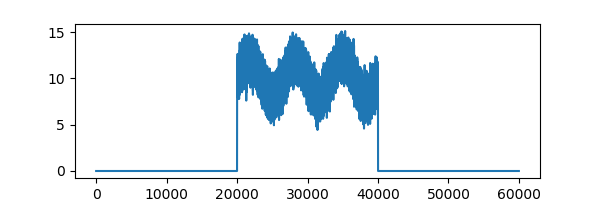

In [13]:
from labdaq import *

%matplotlib notebook
import pylab as plt
plt.figure(figsize=(6,2))
plt.plot(stimgen_waveform([[1,1,0,10,1,0,0,0,0,0],
                           [1,2,1,0,0,0,0,0,0,0],
                           [1,3,2,3,0,0,0,0,0,1],
                           [1,1,10,0,0,0,0,0,1,1],
                          [1,1,0,0,1,0,0,0,0,0]]));
